Преобразуйте изображение в тензоры цветовых каналов R, G, B (можно
использовать инструменты библиотеки matplotlib.image, cv2 или другой на
выбор, см. блокнот от 22.03.2025 с практики)

In [4]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as image

r = np.random.RandomState(69)


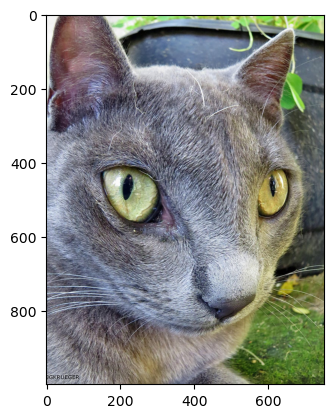

In [5]:
img = image.imread(r'C:\Users\user\PycharmProjects\NAM\lab2\kot-eti-udivitelnye-kotiki.jpg')

plt.imshow(img)
plt.show()

R, G, B = img[:, :, 0] / 0xff, img[:, :, 1] / 0xff, img[:, :, 2] / 0xff


In [6]:
def read_from_shrinked(U, S, VT):
    return (U @ S @ VT)


def restore_image(R, G, B):
    R_restored = read_from_shrinked(R[0], R[1], R[2])
    G_restored = read_from_shrinked(G[0], G[1], G[2])
    B_restored = read_from_shrinked(B[0], B[1], B[2])
    restored_float = np.dstack((R_restored, G_restored, B_restored))
    img_restored = (np.minimum(restored_float, 1.0) * 0xff).astype(np.uint8)

    plt.imshow(img_restored)
    plt.show()


Выполните сингулярное разложение тензоров R, G, B при помощи
степенного метода. Внимание: размеры изображения width, height задают
размер матрицы n, m (учтите это обстоятельство в процедуре при генерации
вектора-начального приближения); число итераций N для степенного метода
N = {10; 50; 100}. Если при расчете появятся отрицательные оценки сингулярных чисел – отметьте это в отчете
и объясните причину (мы же понимаем, что так быть не должно – в чем
ошибка?).

In [7]:
def singular_decomposition(A, N):
    m = A.shape[1]
    r = np.linalg.matrix_rank(A)

    def pm(M, N):
        x = np.ones(m)
        x = x / np.linalg.norm(x, 2)
        for _ in range(N):
            x = M @ x
            x = x / np.linalg.norm(x, 2)
        ev = (M @ x @ x) / (x @ x)
        return ev, x

    M = A.T @ A

    UT = []
    VT = []
    S = []

    for _ in range(r):
        res = pm(M, N)
        lam, v = res[0], res[1]
        s = np.sqrt(lam) if lam > 0 else 0
        if s == 0:
            break
        u = A @ v / s
        UT.append(u)
        S.append(s)
        VT.append(v)
        M = M - lam * np.outer(v, v)

    VT = np.array(VT)
    U = np.array(UT).T
    S = np.diag(S) if S else np.zeros((A.shape[0], A.shape[1]))

    return U, S, VT


N = [10, 50, 100]
R_SVD = [singular_decomposition(R, N_i) for N_i in N]
G_SVD = [singular_decomposition(G, N_i) for N_i in N]
B_SVD = [singular_decomposition(B, N_i) for N_i in N]


Для каждого случая (R, G, B) сравните результаты при
различном числе итераций (проверьте норму разности исходной матрицы и
«восстановленной» из построенного сингулярного разложения). Все операции
можно выполнять с помощью встроенных инструментов numpy, кроме
степенного метода (адаптируйте блокнот с практики).

N = 10, нормы разницы исходной и восстановленной матрицы:
R: 27.0150605689171
G: 72.65311226968387
B: 26.988259758109958


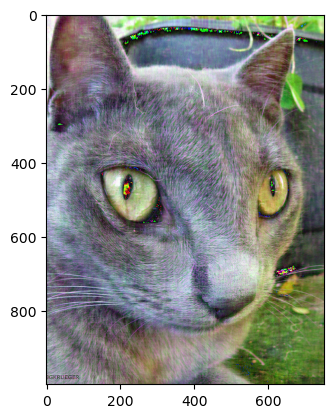

N = 50, нормы разницы исходной и восстановленной матрицы:
R: 5.086063807019247
G: 3.885548191290563
B: 4.51836133986169


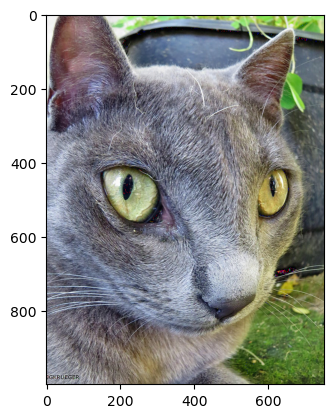

N = 100, нормы разницы исходной и восстановленной матрицы:
R: 1.1435608055100686
G: 2.148860584389862
B: 1.467668097577032


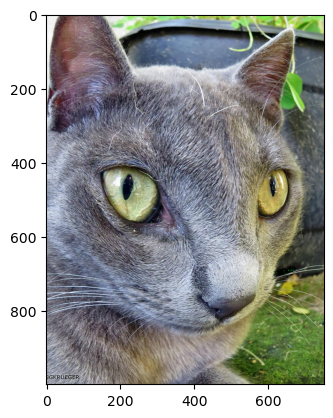

In [8]:
for N_i in range(3):
    print(f'N = {N[N_i]}, нормы разницы исходной и восстановленной матрицы:')
    print(f'R: {np.linalg.norm(R - R_SVD[N_i][0] @ R_SVD[N_i][1] @ R_SVD[N_i][2])}')
    print(f'G: {np.linalg.norm(G - G_SVD[N_i][0] @ G_SVD[N_i][1] @ G_SVD[N_i][2])}')
    print(f'B: {np.linalg.norm(B - B_SVD[N_i][0] @ B_SVD[N_i][1] @ B_SVD[N_i][2])}')
    restore_image(R_SVD[N_i], G_SVD[N_i], B_SVD[N_i])


Для каждой из матриц R, G, B проанализируйте сингулярные числа, их
распределение (можно привести график «порядковый номер – число»).

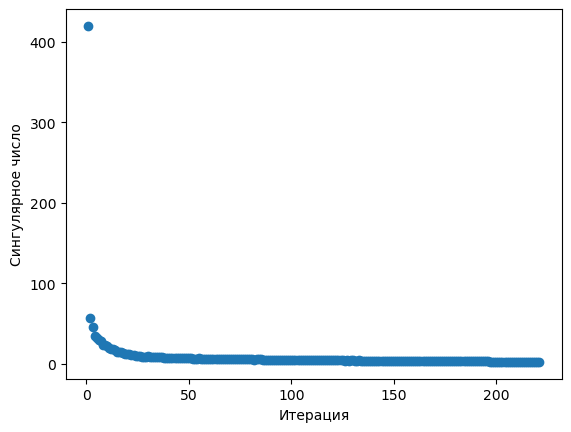

27.0150605689171


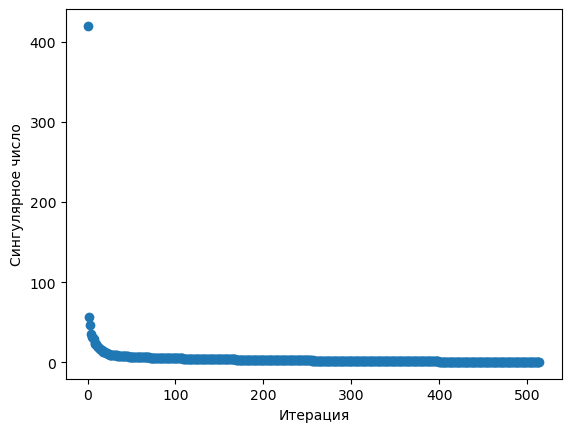

5.086063807019247


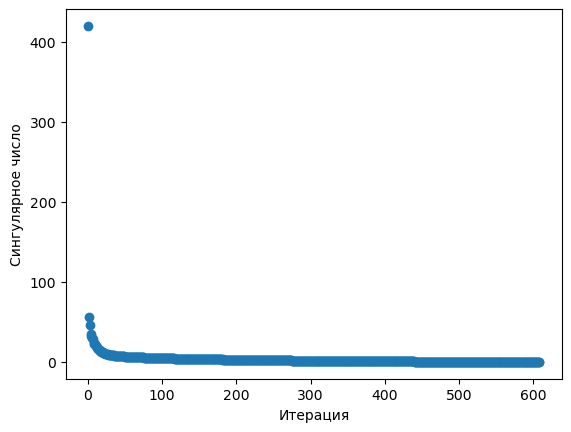

1.1435608055100686


In [9]:
def plot_singular_values(S, i):
    plt.scatter(np.arange(1, S.shape[0] + 1, 1), np.diag(S))
    plt.xlabel('Итерация')
    plt.ylabel('Сингулярное число')
    plt.show()
    print(f'{np.linalg.norm(R - R_SVD[i][0] @ R_SVD[i][1] @ R_SVD[i][2])}')


for i in range(3):
    plot_singular_values(R_SVD[i][1], i)


Предположите, сколько старших сингулярных чисел потребуется в варианте
усеченного сингулярного разложения для того, чтобы визуально качество
восстановленного изображения оказалось приемлемым. Реализуйте усеченное
разложение и проверьте предположение экспериментально (просто экспертная
оценка, визуально, можете сделать сами или обратиться к одногруппникам)

In [10]:
def singular_decomposition_truncated(A, N, k):
    counter = 0
    m = A.shape[1]

    def pm(M, N):
        x = np.ones(m)
        x = x / np.linalg.norm(x, 2)
        for _ in range(N):
            x = M @ x
            x = x / np.linalg.norm(x, 2)
        ev = (M @ x @ x) / (x @ x)
        return ev, x

    M = A.T @ A

    UT = []
    VT = []
    S = []

    for _ in range(k):
        res = pm(M, N)
        lam, v = res[0], res[1]
        s = np.sqrt(lam) if lam > 0 else 0
        if s == 0:
            break
        u = A @ v / s
        UT.append(u)
        S.append(s)
        VT.append(v)
        M = M - lam * np.outer(v, v)
        counter += 1

    VT = np.array(VT)
    U = np.array(UT).T
    S = np.diag(S) if S else np.zeros((A.shape[0], A.shape[1]))

    return U, S, VT, counter


k = [1, 25, 50, 80, 130, 200, 300]
R_T_SVD = [singular_decomposition_truncated(R, 100, k_i) for k_i in k]
G_T_SVD = [singular_decomposition_truncated(G, 100, k_i) for k_i in k]
B_T_SVD = [singular_decomposition_truncated(B, 100, k_i) for k_i in k]


N = 100, k = 1


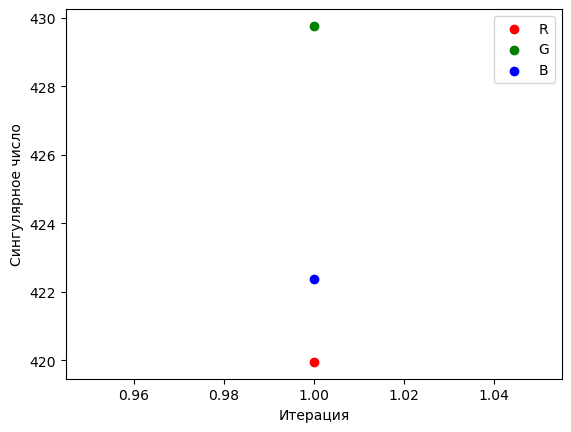

R norm: 139.18069537056093
G norm: 143.6959174106092
B norm: 142.46875234174192


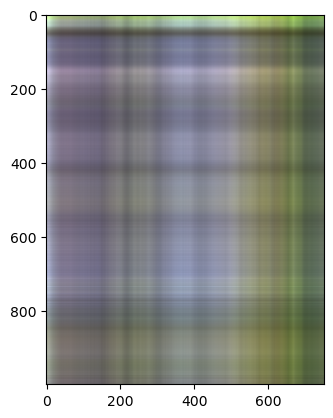

N = 100, k = 25


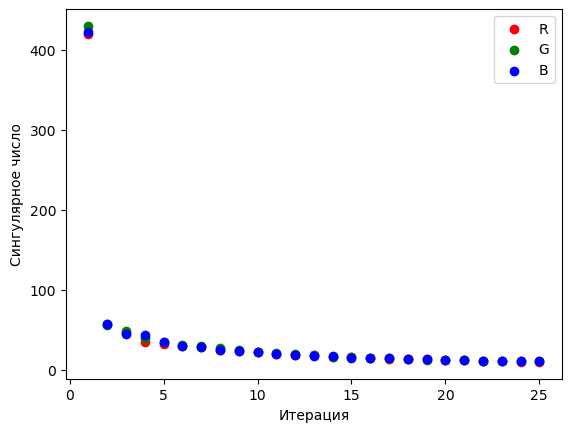

R norm: 73.78158616109442
G norm: 74.59618343156113
B norm: 74.2622811122208


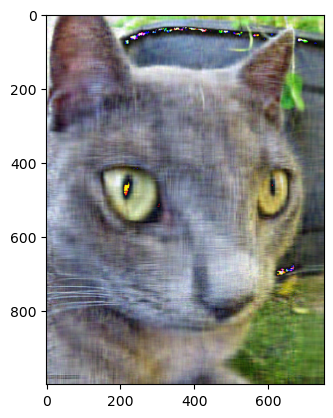

N = 100, k = 50


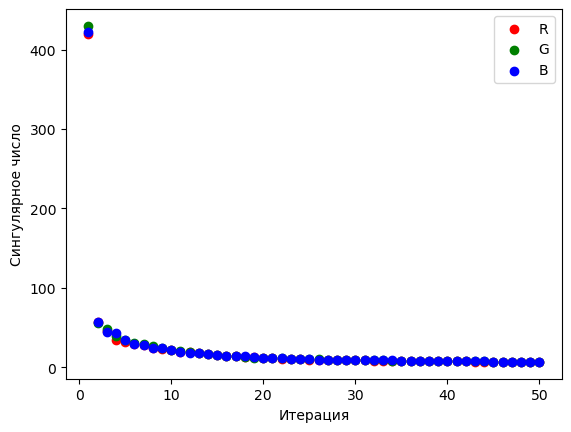

R norm: 61.9032432160944
G norm: 62.25771417263697
B norm: 61.99071022138239


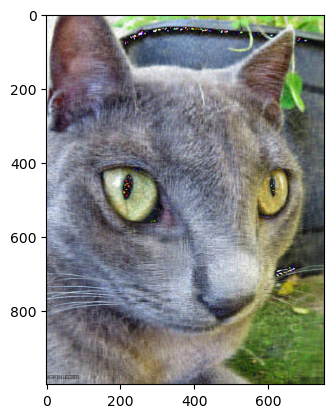

N = 100, k = 80


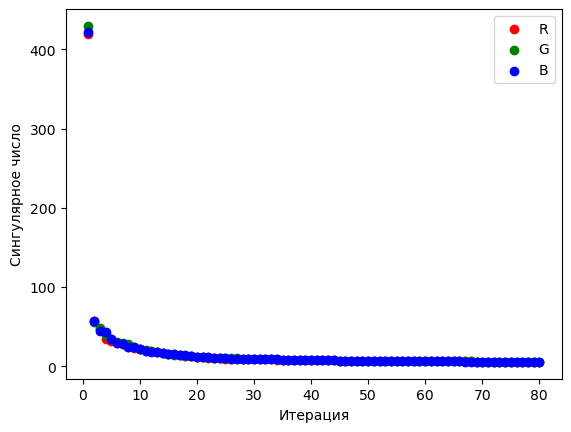

R norm: 51.97039262639793
G norm: 52.143014703788516
B norm: 51.98422946531786


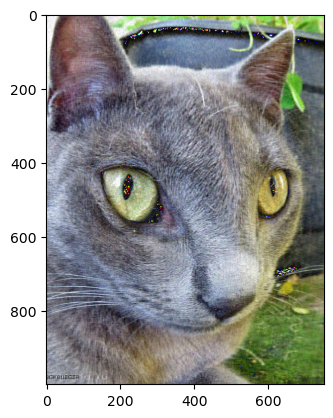

N = 100, k = 130


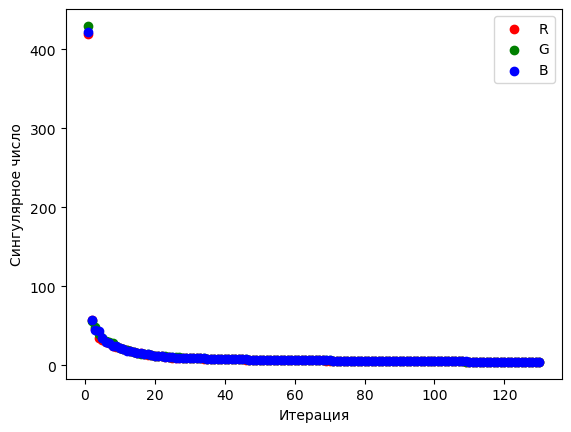

R norm: 39.49140640200622
G norm: 39.54270540813157
B norm: 39.472637169891456


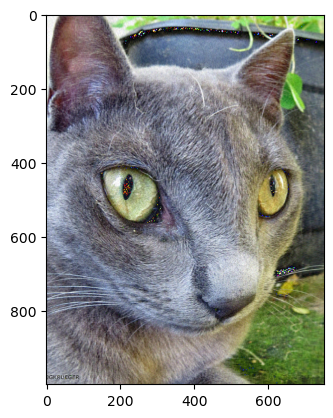

N = 100, k = 200


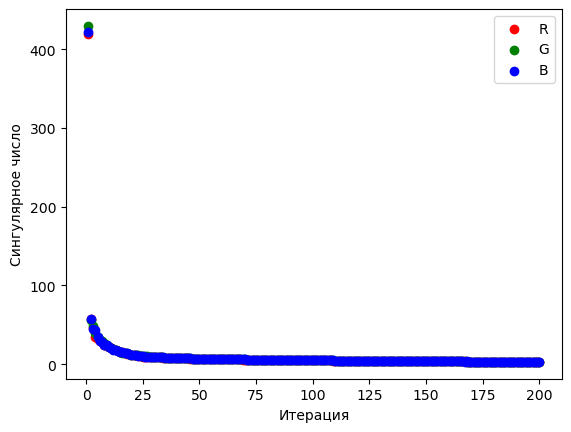

R norm: 26.738537547954877
G norm: 26.707269856005134
B norm: 26.71965592496513


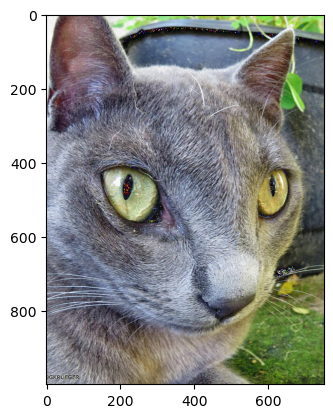

N = 100, k = 300


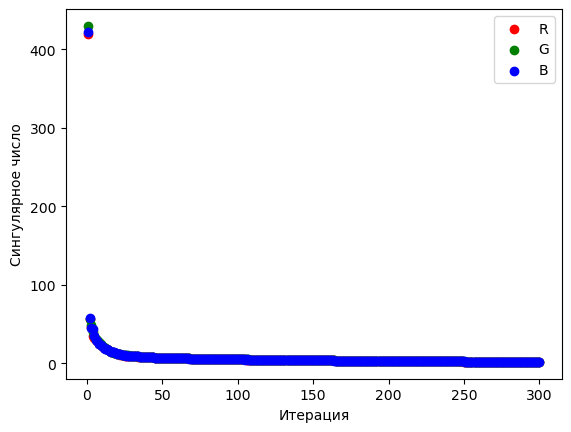

R norm: 14.49890784660883
G norm: 14.454990565220742
B norm: 14.529163644209149


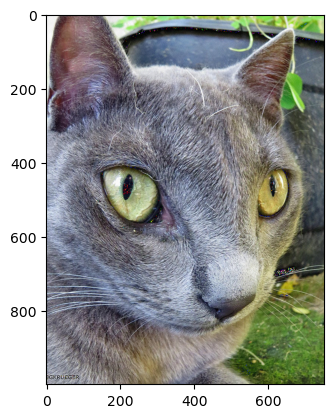

In [11]:
def plot_truncated_singular_values(R_T_SVD, G_T_SVD, B_T_SVD, k):
    print(f'N = 100, k = {k}')
    plt.scatter(np.arange(1, R_T_SVD[1].shape[0] + 1, 1), np.diag(R_T_SVD[1]), color='red', label='R')
    plt.scatter(np.arange(1, G_T_SVD[1].shape[0] + 1, 1), np.diag(G_T_SVD[1]), color='green', label='G')
    plt.scatter(np.arange(1, B_T_SVD[1].shape[0] + 1, 1), np.diag(B_T_SVD[1]), color='blue', label='B')
    plt.xlabel('Итерация')
    plt.ylabel('Сингулярное число')
    plt.legend()
    plt.show()
    print(f'R norm: {np.linalg.norm(R - R_T_SVD[0] @ R_T_SVD[1] @ R_T_SVD[2])}')
    print(f'G norm: {np.linalg.norm(G - G_T_SVD[0] @ G_T_SVD[1] @ G_T_SVD[2])}')
    print(f'B norm: {np.linalg.norm(B - B_T_SVD[0] @ B_T_SVD[1] @ B_T_SVD[2])}')
    restore_image(R_T_SVD, G_T_SVD, B_T_SVD)


for k_i in range(7):
    plot_truncated_singular_values(R_T_SVD[k_i], G_T_SVD[k_i], B_T_SVD[k_i], k[k_i])


Найдите сингулярные числа матрицы R, G либо B (на выбор) при помощи
процедуры на основе метода вращений Якоби (порог tol примите
самостоятельно).

In [12]:
def jacobi_eigenvalues_H(A, tol):
    d = len(A[0])
    A = (A.T) @ A

    err_est = np.linalg.norm(np.triu(A, 1))
    err_est_history = [err_est]

    while err_est > tol:
        p, q = np.unravel_index(np.argmax(np.abs(np.triu(A, 1)), axis=None), A.shape)
        t = 2 * A[p, q] / (A[p, p] - A[q, q])
        S = np.identity(d)
        cos_phi = (0.5 * (1 + (1 + t ** 2) ** -0.5)) ** 0.5
        sin_phi = np.sign(t) * (0.5 * (1 - (1 + t ** 2) ** -0.5)) ** 0.5
        S[p, p] = cos_phi
        S[q, q] = cos_phi
        S[p, q] = -sin_phi
        S[q, p] = sin_phi
        A = (S.T) @ A @ S
        err_est = np.linalg.norm(np.triu(A, 1))
        err_est_history.append(err_est)

    return np.sqrt(np.sort(np.diag(A))), err_est_history


jacobi_res_R = jacobi_eigenvalues_H(R, 200)


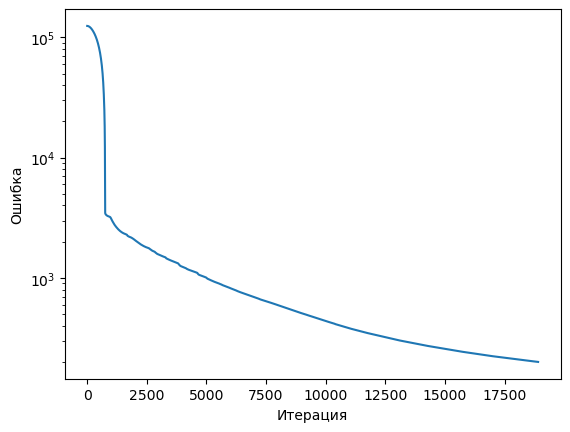

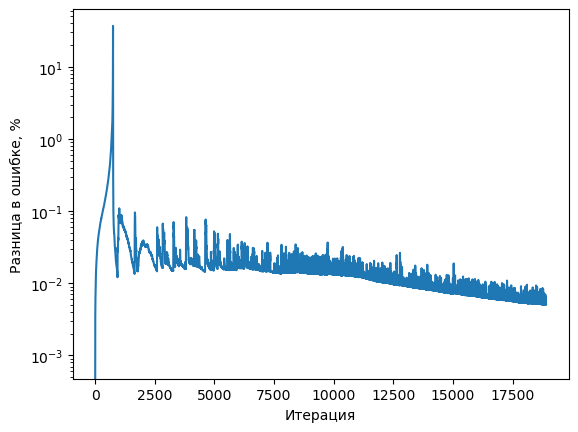

In [13]:
plt.plot(jacobi_res_R[1])
plt.yscale('log')
plt.xlabel('Итерация')
plt.ylabel('Ошибка')
plt.show()

percentage_diffs = [0] + [100 * abs((jacobi_res_R[1][i] - jacobi_res_R[1][i - 1]) / jacobi_res_R[1][i - 1]) for i in
                          range(1, len(jacobi_res_R[1]))]
plt.plot(percentage_diffs)
plt.yscale('log')
plt.xlabel('Итерация')
plt.ylabel('Разница в ошибке, %')
plt.show()


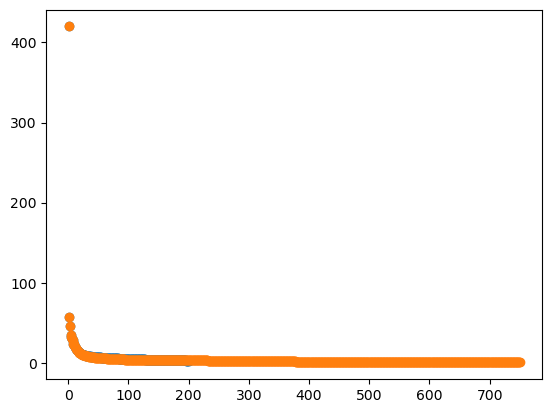

In [39]:
plt.scatter(np.arange(1, R_T_SVD[5][1].shape[0] + 1, 1), np.diag(R_T_SVD[5][1]))
plt.scatter(np.arange(1, jacobi_res_R[0].shape[0] + 1, 1), np.sort(jacobi_res_R[0])[::-1])

Сравните результаты с пунктом 3. Сравните порядок числа
операций, выполненных в том и в другом случае (степенной метод, либо
метод вращений Якоби)

In [40]:
R_T_SVD_sorted = [np.append(np.sort(np.diag(R_T_SVD[i][1]))[::-1], np.zeros(750 - len(R_T_SVD[i][1]))) for i in range(6)]

diff0 = np.linalg.norm(jacobi_res_R[0][::-1] - R_T_SVD_sorted, axis=1)

for i in range(6):
    print(f"Усечённый степенной метод: N = 100, k = {k[i]}")
    print(f"Ошибка метода Якоби относительно SVD: {diff0[i]:.2f}")
    print(f"Разница в итерациях: Степенной метод = {R_T_SVD[i][3] * 100}, Якоби = {len(jacobi_res_R[1])}, "
          f"Разница = {R_T_SVD[i][3] * 100 - len(jacobi_res_R[1])}")
    print()


Усечённый степенной метод: N = 100, k = 1
Ошибка метода Якоби относительно SVD: 139.18
Разница в итерациях: Степенной метод = 100, Якоби = 18904, Разница = -18804

Усечённый степенной метод: N = 100, k = 25
Ошибка метода Якоби относительно SVD: 74.17
Разница в итерациях: Степенной метод = 2500, Якоби = 18904, Разница = -16404

Усечённый степенной метод: N = 100, k = 50
Ошибка метода Якоби относительно SVD: 64.04
Разница в итерациях: Степенной метод = 5000, Якоби = 18904, Разница = -13904

Усечённый степенной метод: N = 100, k = 80
Ошибка метода Якоби относительно SVD: 57.46
Разница в итерациях: Степенной метод = 8000, Якоби = 18904, Разница = -10904

Усечённый степенной метод: N = 100, k = 130
Ошибка метода Якоби относительно SVD: 50.30
Разница в итерациях: Степенной метод = 13000, Якоби = 18904, Разница = -5904

Усечённый степенной метод: N = 100, k = 200
Ошибка метода Якоби относительно SVD: 41.00
Разница в итерациях: Степенной метод = 20000, Якоби = 18904, Разница = 1096



Творчески, опционально (по желанию – сократит число вопросов по
теории, порадует преподавателей): постройте гистограммы глубины цветов
(при помощи np.hist). Сравните параметры эмпирического распределения
(среднее и стандартное отклонение), с количеством сингулярных чисел,
достаточным для приемлемого «восстановления» изображения (пункт 3)

Красный
Среднее = 0.48, Ст. отклонение = 0.18


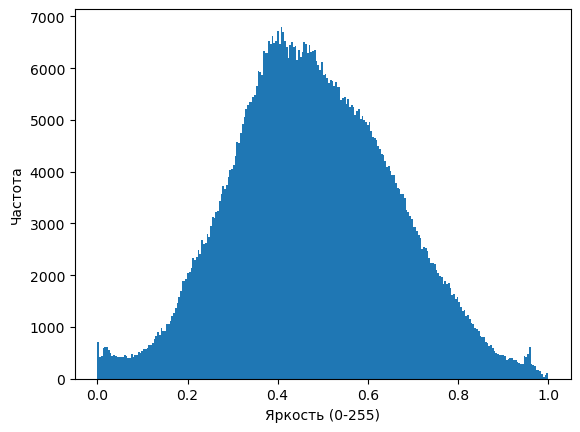

Зелёный
Среднее = 0.49, Ст. отклонение = 0.19


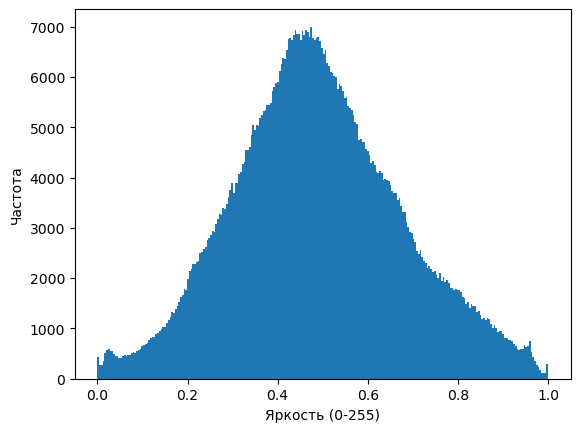

Синий
Среднее = 0.47, Ст. отклонение = 0.20


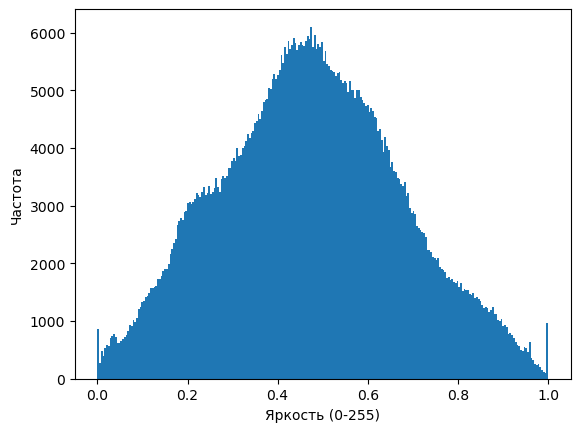

In [15]:
def analysis(channel, name):
    print(name)
    mean_val = np.mean(channel)
    std_val = np.std(channel)
    print(f"Среднее = {mean_val:.2f}, Ст. отклонение = {std_val:.2f}")
    plt.hist(channel.flatten(), bins=256)
    plt.xlabel('Яркость (0-255)')
    plt.ylabel('Частота')
    plt.show()


analysis(R, 'Красный')
analysis(G, 'Зелёный')
analysis(B, 'Синий')
